## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [137]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.gaussian_process import GaussianProcessClassifier
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor

In [296]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


### We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

In [297]:
Data1['log_traffic_counts'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['new_traffic_counts'] = Data1['log_traffic_counts'] - Data1['log_traffic_counts'].mean()
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,log_traffic_counts,new_traffic_counts
0,-80.278366,40.468606,84.0,4.430817,-3.977526
1,-80.162117,40.384598,95.0,4.553877,-3.854466
2,-80.221205,40.366778,97.0,4.574711,-3.833632
3,-80.142455,40.622084,111.0,4.709530,-3.698812
4,-80.131975,40.544915,125.0,4.828314,-3.580029


In [4]:
# your code here

### The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [5]:
x_obs = Data1[['Longitude', 'Latitude']]
y_obs = Data1['new_traffic_counts']

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.3, random_state=42)

In [7]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

In [8]:
gp.fit(x_obs, y_obs)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=1)

### 2) The log marginal likelihood of the training data. (5 pts)

In [10]:
print(gp.log_marginal_likelihood_value_)

-1365.9466919139309


### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

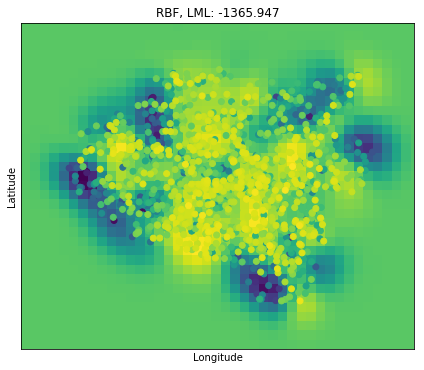

In [230]:
# create a mesh to plot in
x_min, x_max = Data1.Longitude.min() - 0.1, Data1.Longitude.max() + 0.1 
y_min, y_max = Data1.Latitude.min() - 0.1, Data1.Latitude.max() + 0.1 
h = .02 # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.figure(figsize=(6, 6))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Data1.Longitude, Data1.Latitude, c=Data1.new_traffic_counts)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))
plt.tight_layout()
plt.show()

### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [298]:
Data1['pred_traffic'] = gp.predict(Data1[['Longitude', 'Latitude']])

In [299]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,log_traffic_counts,new_traffic_counts,pred_traffic
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.594040
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800837
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.246781
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.251590
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.326580


In [300]:
Data1['standard_deviation'] = Data1.pred_traffic.std() * 2

In [301]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,log_traffic_counts,new_traffic_counts,pred_traffic,standard_deviation
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.594040,1.055257
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800837,1.055257
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.246781,1.055257
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.251590,1.055257
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.326580,1.055257


In [302]:
sum((Data1.new_traffic_counts - Data1.pred_traffic) > Data1.standard_deviation * 2)

0

In [303]:
sum((Data1.new_traffic_counts - Data1.pred_traffic) < Data1.standard_deviation * -2)

16

In [304]:
Data1.pred_traffic.count()

1115

In [305]:
# percentage of sensors have average traffic counts more 
# than two standard deviations higher or lower than the model predicts given 
# their spatial location
(16 + 0) / 1115 * 100

1.4349775784753362

### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [327]:
Data1['indicator'] = (Data1.new_traffic_counts - Data1.pred_traffic) / Data1.standard_deviation


In [328]:
a =[]
for i in Data1['indicator']:
    if i < -2:
        a.append(-1)
    elif i > 2:
        a.append(1)
    else:
        a.append(0)


In [329]:
Data1['label'] = a

In [330]:
Data1.head(10)

,Longitude,Latitude,AvgDailyTrafficCount,log_traffic_counts,new_traffic_counts,pred_traffic,standard_deviation,indicator,label
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.594040,1.055257,-2.258679,-1
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800837,1.055257,-2.893731,-1
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.246781,1.055257,-2.451395,-1
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.251590,1.055257,-2.319079,-1
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.326580,1.055257,-2.135452,-1
5,-80.139674,40.623590,126.0,4.836282,-3.572061,-1.202210,1.055257,-2.245758,-1
6,-79.813385,40.583852,134.0,4.897840,-3.510503,-1.006076,1.055257,-2.373287,-1
7,-80.132048,40.537038,136.0,4.912655,-3.495688,-1.097593,1.055257,-2.272523,-1
8,-80.278168,40.466386,136.0,4.912655,-3.495688,-1.659734,1.055257,-1.739818,0
9,-80.138849,40.591467,141.0,4.948760,-3.459583,-1.626498,1.055257,-1.737098,0


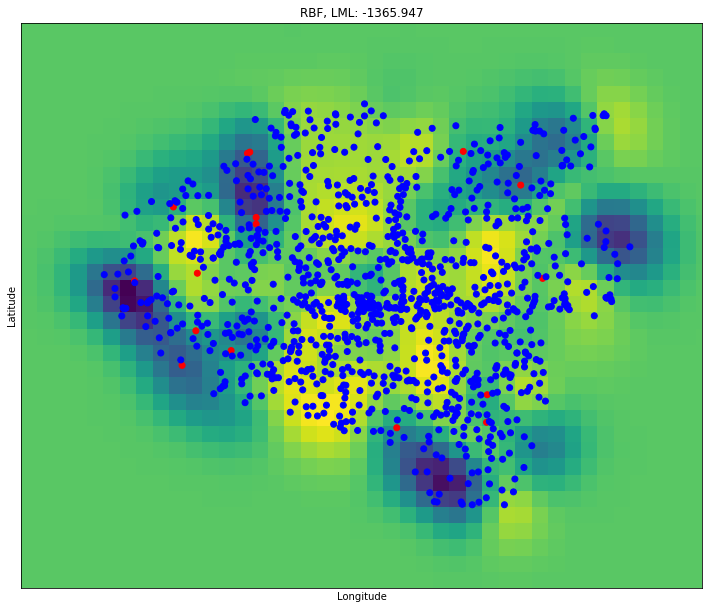

In [334]:
plt.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Data1.Longitude, Data1.Latitude, c=np.array(['b', 'g', 'r'])[Data1.label])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))
plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here
Anomaly; The standard deviation is 0.1, the point is 10 standard deviation away from the center. So it is anomaly.

Not Anomaly; This point is witnin 1 standard deviation of the center. It is not-anomaly.

Anomaly; Even though this point is witnin 1 standard deviation of the center. It only has two points in the cluster. So it is anomaly.

Not Anomaly; This point is witnin 1 standard deviation of the center. It is not-anomaly.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [68]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [69]:
Data2.set_index('County', inplace=True)

In [70]:
# your code here

In [71]:
data2 = Data2[ ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [72]:
data2.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",19,31,254,4.3,18,12.9
"Baldwin, Alabama",19,27,221,4.5,20,13.1
"Barbour, Alabama",21,41,147,5.3,38,12.6
"Bibb, Alabama",21,40,236,4.3,27,12.9
"Blount, Alabama",19,32,219,4.1,24,12.7


In [73]:
data2.dtypes

'\% Smokers'                object
'\% Obese'                   int64
'Violent Crime Rate'        object
'80/20 Income Ratio'        object
'\% Children in Poverty'    object
'Average Daily PM2.5'       object
dtype: object

In [79]:
data2 = data2.convert_objects(convert_numeric=True)

/nfshome/jl9760/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [80]:
for i in data2.iloc[:,0:6]:
    data2[i] = pd.cut(data2[i],5,labels=False)
print(data2.head())

                  '\% Smokers'  '\% Obese'  'Violent Crime Rate'  \
County                                                             
Autauga, Alabama           1.0           2                   0.0   
Baldwin, Alabama           1.0           2                   0.0   
Barbour, Alabama           2.0           4                   0.0   
Bibb, Alabama              2.0           4                   0.0   
Blount, Alabama            1.0           2                   0.0   

                  '80/20 Income Ratio'  '\% Children in Poverty'  \
County                                                             
Autauga, Alabama                   1.0                       1.0   
Baldwin, Alabama                   1.0                       1.0   
Barbour, Alabama                   1.0                       2.0   
Bibb, Alabama                      1.0                       1.0   
Blount, Alabama                    0.0                       1.0   

                  'Average Daily PM2.5'  
Coun

In [81]:
data2.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",1.0,2,0.0,1.0,1.0,3.0
"Baldwin, Alabama",1.0,2,0.0,1.0,1.0,3.0
"Barbour, Alabama",2.0,4,0.0,1.0,2.0,3.0
"Bibb, Alabama",2.0,4,0.0,1.0,1.0,3.0
"Blount, Alabama",1.0,2,0.0,0.0,1.0,3.0


In [82]:
data2.dtypes

'\% Smokers'                float64
'\% Obese'                    int64
'Violent Crime Rate'        float64
'80/20 Income Ratio'        float64
'\% Children in Poverty'    float64
'Average Daily PM2.5'       float64
dtype: object

In [83]:
data2["'\% Obese'"] = data2["'\% Obese'"].astype('float64')

In [84]:
data2.isna().any()

'\% Smokers'                 True
'\% Obese'                  False
'Violent Crime Rate'         True
'80/20 Income Ratio'         True
'\% Children in Poverty'     True
'Average Daily PM2.5'        True
dtype: bool

In [85]:
data2 = data2.dropna()

In [86]:
data2[data2.columns] = data2[data2.columns].astype('int64')

In [87]:
data2.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,1,2,3
"Bibb, Alabama",2,4,0,1,1,3
"Blount, Alabama",1,2,0,0,1,3


In [88]:
data2.isna().any()

'\% Smokers'                False
'\% Obese'                  False
'Violent Crime Rate'        False
'80/20 Income Ratio'        False
'\% Children in Poverty'    False
'Average Daily PM2.5'       False
dtype: bool

### (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

In [89]:
hc = HillClimbSearch(data2, scoring_method=BicScore(data2))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'\\% Obese'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'80/20 Income Ratio'", "'Violent Crime Rate'"), ("'80/20 Income Ratio'", "'\\% Children in Poverty'")]


### (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [90]:
model = BayesianModel(best_model.edges())
model.fit(data2, estimator=MaximumLikelihoodEstimator)

In [91]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [92]:
exmp=data2.apply(lambda x: LL(x,model),axis=1)

In [93]:
print(exmp.sort_values().head(5))

County
New York, New York           -14.949340
Kenedy, Texas                -13.838691
Suffolk, Massachusetts       -13.632577
Orangeburg, South Carolina   -13.371240
Clayton, Georgia             -13.345084
dtype: float64


### Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

### (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [335]:
Data3=pd.read_csv("2016CountyHealthIndicators.csv")

In [336]:
Data3.set_index('County', inplace=True)

In [337]:
data3 = Data3[ ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [343]:
data3 = data3.convert_objects(convert_numeric=True)

/nfshome/jl9760/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [344]:
data3.isna().any()

'\% Smokers'                 True
'\% Obese'                  False
'Violent Crime Rate'         True
'80/20 Income Ratio'         True
'\% Children in Poverty'     True
'Average Daily PM2.5'        True
dtype: bool

In [345]:
data3 = data3.dropna()

In [346]:
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(data3)

In [347]:
res=pd.DataFrame(KM.transform(data3))
res.head()

,0,1,2
0,94.702827,127.525879,461.141644
1,127.579146,94.563706,494.112193
2,202.016451,28.511758,568.056649
3,112.774603,110.064140,479.025324
4,129.400105,92.526057,496.005409


In [348]:
res.set_index(data3.index, inplace=True)

In [349]:
res.head()

,0,1,2
County,,,
"Autauga, Alabama",94.702827,127.525879,461.141644
"Baldwin, Alabama",127.579146,94.563706,494.112193
"Barbour, Alabama",202.016451,28.511758,568.056649
"Bibb, Alabama",112.774603,110.064140,479.025324
"Blount, Alabama",129.400105,92.526057,496.005409


In [350]:
res=pd.DataFrame(KM.transform(data3))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(data3))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]


,0,1,2,cluster,score
1475,1536.737001,1758.619061,1170.125009,2,1170.125009
98,1415.740393,1637.620920,1049.125109,2,1049.125109
1129,1100.647585,1322.518497,734.050805,2,734.050805
552,1077.957101,1299.842185,711.371879,2,711.371879
2177,1002.651686,1224.524321,636.055287,2,636.055287


In [351]:
res.set_index(data3.index, inplace=True)

In [352]:
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
County,,,,,
"St. Louis City, Missouri",1536.737001,1758.619061,1170.125009,2,1170.125009
"Crittenden, Arkansas",1415.740393,1637.620920,1049.125109,2,1049.125109
"Baltimore City, Maryland",1100.647585,1322.518497,734.050805,2,734.050805
"Alexander, Illinois",1077.957101,1299.842185,711.371879,2,711.371879
"Greenwood, South Carolina",1002.651686,1224.524321,636.055287,2,636.055287


### (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [353]:
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(data3)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [354]:
GM_log = pd.DataFrame(GM.score_samples(data3))

In [355]:
GM_log.head()

,0
0,-15.343505
1,-15.965211
2,-20.515938
3,-18.206816
4,-14.569364


In [356]:
GM_log.set_index(data3.index, inplace=True)

In [357]:
GM_log.head()

,0
County,
"Autauga, Alabama",-15.343505
"Baldwin, Alabama",-15.965211
"Barbour, Alabama",-20.515938
"Bibb, Alabama",-18.206816
"Blount, Alabama",-14.569364


In [358]:
GM_log.sort_values(0)[:5]

,0
County,
"St. Louis City, Missouri",-31.651780
"Roulette, North Dakota",-31.456629
"Sioux, North Dakota",-31.279179
"New York, New York",-31.084746
"Shannon, South Dakota",-28.157407


### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

In [359]:
# LOF
# Local outlier factor (LOF).
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(data3)

/nfshome/jl9760/.conda/envs/myEnv/lib/python3.5/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=20, novelty=False, p=2)

In [360]:
LOF_anomaly = pd.DataFrame(clf._decision_function(data3))

In [361]:
LOF_anomaly.head()

,0
0,0.193725
1,0.171721
2,-0.122160
3,0.141897
4,0.214124


In [362]:
LOF_anomaly.set_index(data3.index, inplace=True)

In [363]:
LOF_anomaly.sort_values(0)[:5]

,0
County,
"St. Louis City, Missouri",-1.589724
"Crittenden, Arkansas",-1.200237
"Shannon, South Dakota",-0.832285
"Clay, Georgia",-0.685727
"Sioux, North Dakota",-0.667190


### Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [364]:
bayesion = exmp.sort_values()[:5]
kmean = res.sort_values("score",ascending=False)[:5]
gm = GM_log.sort_values(0)[:5]
lof = LOF_anomaly.sort_values(0)[:5]

In [365]:
bayesion = pd.DataFrame(bayesion)

In [366]:
kmean = pd.DataFrame(kmean.score)

In [367]:
kmean.columns = ['0']

In [368]:
kmean.head()

,0
County,
"St. Louis City, Missouri",1170.125009
"Crittenden, Arkansas",1049.125109
"Baltimore City, Maryland",734.050805
"Alexander, Illinois",711.371879
"Greenwood, South Carolina",636.055287


In [371]:
table = kmean.join(gm, how='outer', lsuffix=' ').join(lof, how='outer', lsuffix=' ')

In [372]:
table

,0,0,0
County,,,
"Alexander, Illinois",711.371879,NaN,NaN
"Baltimore City, Maryland",734.050805,NaN,NaN
"Clay, Georgia",NaN,NaN,-0.685727
"Crittenden, Arkansas",1049.125109,NaN,-1.200237
"Greenwood, South Carolina",636.055287,NaN,NaN
"New York, New York",NaN,-31.084746,NaN
"Roulette, North Dakota",NaN,-31.456629,NaN
"Shannon, South Dakota",NaN,-28.157407,-0.832285
"Sioux, North Dakota",NaN,-31.279179,-0.667190


### There are some counties that were found to be anomalous in some models and not in others. (Crittenden, Arkansas), (Shannon, South Dakota), (Sioux, North Dakota), (St. Louis City, Missouri	) appeared more than once. I am not really familiar with these cities but I think the reason might be they all have high population density or have high population density areas.